# Updating a proofreading table or a list id file

This notebook contains functions and example scripts to update a proofreading table or lists of ids stored in an excel or txt file

Content per section:
<br>A) Updating IDs and presynaptic counts
<br>B) Updating main postsynaptic neurons database (table)
<br>C) Updating a list of IDs from a txt file

In [2]:
import os
import pandas as pd
import numpy as np
import fafbseg
import math
import itertools
from fafbseg import flywire
from caveclient import CAVEclient
from helpers.synapse_queries import combine_xyz, separate_xyz, synapse_count, filter_points, calculate_distance
client = CAVEclient('flywire_fafb_production')

## A) Updating IDs and presynaptic counts

### 1. Loading Tm9 input neuron table

In [3]:
# Choose path and file
dataPath = r'D:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230704'
fileName = f'Tm1_neurons_input_count_L_{date}.xlsx'
filePath = os.path.join(dataPath,fileName)

In [4]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
df.head()

,presynaptic_ID,counts,count %,postsynaptic_ID,symbol,guess,lab,author,name,detached_lamina (Y/N),...,Update_confidence,Updated_counts,duplicates,Working on,column_id,patch_id,optic_lobe_id,hemisphere,Updated_postsynaptic_ID,dorso-ventral
0,asdf,NaN,NaN,asdf,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,asdf,NaN
1,720575940625266446,182.0,NaN,720575940613257330,L2,NaN,Mathias Wernet,Gizem Sancer,"Lamina monopolar cell 2, L2, L2_R, FBbt_000037...",N,...,1,155.0,1.0,NaN,D4,D,L31,L,720575940613257330,D
2,720575940630712571,26.0,NaN,720575940613257330,C3,NaN,Mathias Wernet,Gizem Sancer,"Centrifugal neuron 3, C3, C3_R, [FBbt_00003744...",N,...,1,22.0,1.0,NaN,D4,D,L31,L,720575940613257330,D
3,720575940618483796,22.0,NaN,720575940613257330,Mi13,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Medullary intrinsic neuron Mi13, Mi13, Mi13_R,...",N,...,1,20.0,1.0,NaN,D4,D,L31,L,720575940613257330,D
4,720575940612468709,19.0,NaN,720575940613257330,Mi9,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Medullary intrinsic neuron 9, Mi9, Mi9_R, FBbt...",N,...,1,14.0,1.0,NaN,D4,D,L31,L,720575940613257330,D


In [5]:
#Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
if df["postsynaptic_ID"][0] == 'asdf': 
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)

#df = df[df['counts'] >= 3].copy() # Removing rows based on absolute count filter
    
#Getting the lists of IDs to update
segmentIDs = df["seg_id"].copy()
pre_IDs = df["presynaptic_ID"].copy()
post_IDs = df["postsynaptic_ID"].copy()


In [6]:
#Replacing the 'INPUTS PROOFREAD' labelled row of the lists for the previous postsynaptic cell ID
for i, id in enumerate(pre_IDs):
    if id == 'INPUTS PROOFREAD':
        segmentIDs[i] = post_IDs[i-1] # The previous postsynaptic cell ID
        pre_IDs[i] = post_IDs[i-1]
        post_IDs[i] = post_IDs[i-1]

### 2. Updating IDs considering our excel file extructure (fast and new version)

In [7]:
#Updating segments (trying to update in loops to not collapse the server)

confidence_of_update = []
updated_presynaptic_ID_column = []
pre_ID_i = 0
rounds_of = 100
curr_round = 0
print(f'Total rounds to perform: {math.ceil((len(pre_IDs)/rounds_of))}')

for i in range(0,math.ceil((len(pre_IDs)/rounds_of))):
    curr_round += 1
    curr_pre_IDs = pre_IDs[pre_ID_i:pre_ID_i+rounds_of]
    temp_segmentIDs_df = flywire.update_ids(curr_pre_IDs.tolist(), stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    updated_presynaptic_ID_column.append(temp_segmentIDs_df["new_id"].tolist())
    confidence_of_update.append(temp_segmentIDs_df["confidence"].tolist())
    pre_ID_i +=rounds_of
    if curr_round%5 == 0: #printing current round every 5 rounds
        print(curr_round)

updated_presynaptic_ID_column = list(itertools.chain.from_iterable(updated_presynaptic_ID_column))
confidence_of_update = list(itertools.chain.from_iterable(confidence_of_update))

Total rounds to perform: 155


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

5


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

10


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

15


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

20


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

25


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

30


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

35


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

40


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

45


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

50


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

55


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

60


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

65


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

70


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

75


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

80


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

85


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

90


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

95


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

100


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

105


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

110


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

115


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

120


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

125


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

130


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

135


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

140


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

145


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

150


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

Updating:   0%|          | 0/22 [00:00<?, ?it/s]

155


### 2. Updating IDs considering our excel file extructure (old and slow version) - DO NOT USE -

Updating segments will be slow since we do it in a loop. Please just run this part if you really consider that the IDs in which your are mostly interested in need an update

In [ ]:
#Updating segments 
updated_presynaptic_ID_column = []
confidence_of_update = []
count = 1
for id in pre_IDs:
    count =+ 1
    if id == 'INPUTS PROOFREAD':
        updated_presynaptic_ID_column.append('INPUTS PROOFREAD')
        confidence_of_update.append('INPUTS PROOFREAD')
    else:
        temp_segmentIDs_df = flywire.update_ids(id, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        updated_presynaptic_ID_column.append(str(temp_segmentIDs_df["new_id"][0]))
        confidence_of_update.append(temp_segmentIDs_df["confidence"][0])
    print(f'row: {count} {updated_presynaptic_ID_column[-1]}')
    

### 2.1 Adding important columns for next steps

In [8]:
### Setting important columns to str
df["presynaptic_ID"] = df["presynaptic_ID"].astype(str)
df["postsynaptic_ID"] = df["postsynaptic_ID"].astype(str)
df["seg_id"] = df["seg_id"].astype(str)

In [9]:
### Updating the dataframe
# Adding the new url column to the data frame
df["Updated_presynaptic_ID"] = updated_presynaptic_ID_column
df["Updated_presynaptic_ID"] = df["Updated_presynaptic_ID"].astype(str) 
df["Update_confidence"] = confidence_of_update

In [10]:
len(confidence_of_update)

15422

### 3. Updating counts between pre- and post synaptic partners

Strategy to save time:
1. (Step1) Create a dictionary with postsynaptic neuron's IDs as KEYS and their a input-neuron dataframe as VALUES , and then (step2) create a loop across presynaptic IDs to get the exact counting from the input-neuron-dataframe of postsynaptic neurons, loading the correct input-neuron-dataframe from the dictionary each time.

    Or, all in one single step: start a loop across unique postsynaptic IDs (be careful that the order is in the same as in the excel file, print them), get the input-neuron dataframe per each one in each round of the loop, and add a second loop across presynaptic IDs to get the exact counting.
    

2. Save the new countings in order of production in the same dataframe, as well as a column showing duplicated rows

In [11]:
#Implementing the "single step" option

unique_post_IDs = df[df['presynaptic_ID'] != 'INPUTS PROOFREAD']['postsynaptic_ID'].unique()
new_count_ls =  [] # For storing the new counts
copy_count_ls = [] # For storing the copy counts 
for post_id in unique_post_IDs: # loop across postsynaptic ids.
    if flywire.is_latest_root([post_id])[0]:
        curr_id = post_id
        #print(f'Getting inputs from: {curr_id}')
    else:
        updated_ID_df = flywire.update_ids(post_id, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        curr_id = updated_ID_df["new_id"][0]
        #print(f'Getting inputs from: {curr_id}')
    
    curr_df = df[df['postsynaptic_ID'] == post_id].copy()
    curr_neurons_inputs = flywire.synapses.fetch_synapses(curr_id, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    
    #Filtering redundant / duplicated counts (threshold = 100 nm)
    combine_xyz(curr_neurons_inputs)
    points = curr_neurons_inputs['pre_pt_position'].tolist()
    points_no_duplicates = filter_points(points, threshold_distance = 100)
    curr_neurons_inputs_no_duplicates = curr_neurons_inputs[curr_neurons_inputs['pre_pt_position'].apply(lambda x: x in points_no_duplicates)].copy()
    
    pre_id_copies_dict = {} # For checking ID duplicates, triplicates, etc
    for i,pre_id in enumerate(curr_df["Updated_presynaptic_ID"]): # loop across presynaptic ids
        #Counting copies
        if pre_id in pre_id_copies_dict.keys():
            pre_id_copies_dict[pre_id]+= 1 # duplicates, triplicates ...
        else:
            pre_id_copies_dict[pre_id] = 1 # initial count
    
        c = len(curr_neurons_inputs_no_duplicates[curr_neurons_inputs_no_duplicates['pre_pt_root_id'] == int(pre_id)])
        new_count_ls.append(c) # count between specific pre and post
        copy_count_ls.append(pre_id_copies_dict[pre_id])
        #print(f'Counts with {pre_id}: {c}, confidence {curr_df["Update_confidence"].tolist()[i]}, copy {pre_id_copies_dict[pre_id]}')
    
    #In old files with this rows acting as separators
    #new_count_ls.append('INPUTS PROOFREAD')
    c#opy_count_ls.append('INPUTS PROOFREAD')
        


In [12]:
# Adding new columns to the main dataframe
df["Updated_counts"] = new_count_ls
df["duplicates"] =  copy_count_ls
df.head()

,presynaptic_ID,counts,count %,postsynaptic_ID,symbol,guess,lab,author,name,detached_lamina (Y/N),...,Update_confidence,Updated_counts,duplicates,Working on,column_id,patch_id,optic_lobe_id,hemisphere,Updated_postsynaptic_ID,dorso-ventral
0,720575940625266446,182.0,NaN,720575940613257330,L2,NaN,Mathias Wernet,Gizem Sancer,"Lamina monopolar cell 2, L2, L2_R, FBbt_000037...",N,...,1.0,155,1,NaN,D4,D,L31,L,720575940613257330,D
1,720575940630712571,26.0,NaN,720575940613257330,C3,NaN,Mathias Wernet,Gizem Sancer,"Centrifugal neuron 3, C3, C3_R, [FBbt_00003744...",N,...,1.0,22,1,NaN,D4,D,L31,L,720575940613257330,D
2,720575940618483796,22.0,NaN,720575940613257330,Mi13,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Medullary intrinsic neuron Mi13, Mi13, Mi13_R,...",N,...,1.0,20,1,NaN,D4,D,L31,L,720575940613257330,D
3,720575940612468709,19.0,NaN,720575940613257330,Mi9,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Medullary intrinsic neuron 9, Mi9, Mi9_R, FBbt...",N,...,1.0,14,1,NaN,D4,D,L31,L,720575940613257330,D
4,720575940630918028,14.0,NaN,720575940613257330,Tm16,NaN,Marion Silies,Sebastian Mauricio Molina Obando,"Transmedullary neuron 16, Tm16, FBbt_00003804 ...",N,...,1.0,10,1,NaN,D4,D,L31,L,720575940613257330,D


### 4. Saving back to the excell file

In [13]:
# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

df.to_excel(writer, sheet_name='Updated_dataframe_'+date_str)
writer.save()
writer.close()

### 3. Or, saving in a new excel file

In [56]:
#Saving in a new file

import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

file_name = f'All_Tm9_neurons_input_count_segments_update_{date_str}.xlsx'
savePath = os.path.join(dataPath, file_name)
df.to_excel(savePath, sheet_name='Segments update')

### Faster update (code in progress...)

In [ ]:
#Updating segments (FAST)
#Do all segments as once, but filter out columns with 'INPUTS PROOFREAD' first
filtered_df = df[df["presynaptic_ID"] =! 'INPUTS PROOFREAD'].copy()
segmentIDs = filtered_df["seg_id"]
pre_IDs = filtered_df["presynaptic_ID"]
post_IDs = filtered_df["postsynaptic_ID"]

new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_segmentIDs = new_segmentIDs_df["new_id"].tolist()


In [ ]:
### Updating the dataframe
# Adding the new url column to the data frame
filtered_df["Updated_seg_id"] = new_segmentIDs
filtered_df["Updated_seg_id"] = filtered_df["Updated_seg_id"].astype(str) 

In [ ]:
# Code not finished....

# B) Updating main postsynaptic neurons database

### 1. Loading postsynaptic neuron dataframe

In [33]:
# Choose path and file
dataPath = r'E:\Connectomics-Data\FlyWire\Excels\drive-data-sets'
date = '20230621'
fileName = 'Tm1 proofreadings_20230105.xlsx'
fileName = 'T4 proofreadings dorsal_20230406.xlsx'
fileName = f'Tm9 proofreadings_{date}.xlsx'

filePath = os.path.join(dataPath,fileName)

In [34]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
if df["seg_id"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)
df = df.astype(str)
display(df.head())
segmentIDs = df["seg_id"].tolist()

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,optic_lobe_id,patch_id,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N)
0,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940631867211,"Fischbach & Dittrich, 1989",...,L1,V,V1,Y,N,N,nan,N,nan,?
1,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,"Fischbach & Dittrich, 1989",...,L2,V,V2,Y,Y,Y,?,N,?,Y
2,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619904728,"Fischbach & Dittrich, 1989",...,L3,V,V3,Y,Y,Y,Y,N,N,Y
3,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626539592,"Fischbach & Dittrich, 1989",...,L4,V,V4,N,N,N,nan,Y,nan,?
4,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616954181,"Fischbach & Dittrich, 1989",...,L5,V,V5,Y,N,N,nan,N,nan,?


### 2. Update with CAVE (not preferred)

In [ ]:
#Update IDs witth chunkedgraph module of CAVE

# For "segmentsIDs"
#Empty spaces are type float and will be filled with "0"
segmentsIDs_int = list(map(lambda x: 0 if type(x) == float else int(x),segmentIDs)) # From str to int
#to create a np.zeros array is important for the next step
new_segmentsIDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),segmentsIDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_segmentsIDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_segmentsIDs_int)) # From int to str

In [ ]:
# For "pre_IDs"
#Empty spaces are type float and will be filled with "0"
pre_IDs_int = list(map(lambda x: 0 if type(x) == float or x == 'INPUTS PROOFREAD'  else int(x),pre_IDs)) # From str to int
#to create a np.zeros array is important for the next step
new_pre_IDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),pre_IDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_pre_IDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_pre_IDs_int)) # From int to str

In [ ]:
# For "post_IDs"
#Empty spaces are type float and will be filled with "0"
post_IDs_int = list(map(lambda x: 0 if type(x) == float else int(x),post_IDs)) # From str to int
#to create a np.zeros array is important for the next step
new_post_IDs_int = list(map(lambda x: np.zeros(1) if x == 0 else client.chunkedgraph.get_latest_roots(x),post_IDs_int))
#Updated IDs leading to more than one ID a single ID will be kept inside [] brakets.
new_post_IDs_str = list(map(lambda x: str(x[0]) if x.size == 1 else x,new_post_IDs_int)) # From int to str

In [ ]:
### Seleting the right pre_ID if the update gaves more than one
#Getting the correct pre_IDs than contact each post_ID

from functools import reduce

correct_IDs = {}
curr_post_ID = 'Start'
for idx,pre_IDs in  enumerate(new_pre_IDs_str):
        
    #If there are multiple IDs in an array
    if type(pre_IDs) != str and type(pre_IDs) == np.ndarray:
        #Creatting synapses dataframe only once per each post_ID
        if curr_post_ID != new_post_IDs_str[idx]:
            synapses = flywire.synapses.fetch_synapses(new_post_IDs_str[idx], pre=False, post=True, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True,mat="live")
            #Update post_ID
            print(f"Looking at post_ID: {new_post_IDs_str[idx]}") 
            curr_post_ID = new_post_IDs_str[idx]
            
        #Proof connectivity to the respective post_ID for each of them
        for ID in pre_IDs:
            if synapses[synapses['pre'] == ID].empty:
                continue
            else: # Only add the pre_ID (and its index) which has valid synapses with the post_IDs
                if idx in correct_IDs.keys(): # If there is already a valid ID, add other valid IDs 
                    curr_value =correct_IDs[idx]
                    new_value = curr_value+"_"+str(ID)
                    correct_IDs[idx] =new_value
                else:
                    correct_IDs[idx]=str(ID)

# Fixing the updated pre_IDs_str_list
for key, value in correct_IDs.items():
    new_pre_IDs_str[key] = value
    


In [ ]:
### Updating the dataframe
# Adding the new url column to the data frame
df["Updated_pre_IDs"] = new_pre_IDs_str
df["Updated_post_IDs"] = new_post_IDs_str

### 2. Update with FAFB (predered)

In [35]:
# Updating the segmentIDs
new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/1375 [00:00<?, ?it/s]

In [36]:
new_segmentIDs_df["confidence"].unique()

array([1.  , 0.96, 0.84, 0.99, 0.89, 0.93, 0.71, 0.9 , 0.8 , 0.79])

In [37]:
### Updating the dataframe
# Adding the new column to the data frame
df["Update_confidence"] = new_segmentIDs_df["confidence"].astype(str).tolist()
df["Updated_seg_id"] = new_segmentIDs_df["new_id"].astype(str).tolist()
df.head()

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id
0,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940631867211,"Fischbach & Dittrich, 1989",...,V1,Y,N,N,nan,N,nan,?,1.0,720575940631867211
1,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,"Fischbach & Dittrich, 1989",...,V2,Y,Y,Y,?,N,?,Y,1.0,720575940629938298
2,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619904728,"Fischbach & Dittrich, 1989",...,V3,Y,Y,Y,Y,N,N,Y,1.0,720575940619904728
3,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626539592,"Fischbach & Dittrich, 1989",...,V4,N,N,N,nan,Y,nan,?,1.0,720575940626539592
4,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616954181,"Fischbach & Dittrich, 1989",...,V5,Y,N,N,nan,N,nan,?,1.0,720575940616954181


In [38]:
#Checking duplicates in ids
df[df["Updated_seg_id"].duplicated() == True]

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id


In [39]:
#Checking updated ids
df[df["Update_confidence"].astype(float) < 1.]

,XYZ-ME,symbol,XYZ-LO,quality comment,hemisphere,lab,author,name,seg_id,identified_in,...,column_id,backbone proofread (Y/N),twigs proofread (Y/N),inputs_proofread (Y/N),dark_neurons (Y/N),bad_quality_rim (Y/N),healthy_L3 (Y/N),detached_lamina (Y/N),Update_confidence,Updated_seg_id
116,nan,Tm9,nan,nan,L,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940621607028,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.96,720575940629278214
251,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940626517946,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.84,720575940622074544
283,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940612717994,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.99,720575940644596640
298,nan,Tm9,nan,nan,L,Marion Silies,Annika Bast,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940632434003,"Fischbach & Dittrich, 1989",...,nan,Y,Y,N,nan,N,nan,?,0.89,720575940629009351
426,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940628500930,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.93,720575940615252945
544,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940619292888,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.89,720575940618302557
547,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940660540545,"Fischbach & Dittrich, 1989",...,nan,N,needs a bit of proofreading,N,nan,N,nan,?,0.71,720575940624099625
578,nan,Tm9,nan,nan,L,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940627340563,"Fischbach & Dittrich, 1989",...,nan,Y,N,N,nan,N,nan,?,0.9,720575940628554005
611,nan,Tm9,nan,nan,L,Marion Silies,Lena Lörsch,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940616958294,"Fischbach & Dittrich, 1989",...,nan,N,needs proofreading,N,nan,N,check comments (mi),?,0.8,720575940618444518
1348,nan,Tm9,nan,nan,R,Eyewire,Krzysztof Kruk,Tm9; Transmedullary neuron 9; FBbt_00003797,720575940610257859,"Fischbach & Dittrich, 1989",...,nan,Y,nan,N,nan,nan,nan,N,0.79,720575940614168291


### 3. If wished: Reorder rows based on condition

In [ ]:
sorted_df = df.sort_values(by = 'cluster_id').copy()

In [39]:
sorted_df = df.copy()

In [57]:
df["seg_id"]

0       720575940631867211
1       720575940629938298
2       720575940619904728
3       720575940626539592
4       720575940616954181
               ...        
1370    720575940602880736
1371    720575940612861462
1372    720575940620517312
1373    720575940615223199
1374    720575940619077686
Name: seg_id, Length: 1375, dtype: int64

### 3. If wished: Add specific column status based on another file

### 3.1 Based on a txt with list od ids

In [190]:
# Selecting column for the update and file from which the info comes
column_to_update = 'inputs_proofread (Y/N)' # 'inputs_proofread (Y/N)', detached_lamina (Y/N)
update_file_path = r'D:\Connectomics-Data\FlyWire\Txts\inputs_proofread'
update_file_with = 'root_ids_Tm9_left_optic_lobe_selection1_plus_patches.txt' # list of ids
update_file_with = 'root_ids_Tm9_left_optic_lobe_selection1_lamina_attached_only_more_strict.txt' # list of ids
update_file_with = 'root_ids_Tm9_right_optic_lobe_selection1.txt' # list of ids
update_file_with = 'root_ids_Tm9_all_input_proofread_20230609.txt' # list of ids

update_filePath =os.path.join(update_file_path,update_file_with)

# extractring info from the specific file
update_file_with_df = pd.read_csv(update_filePath)
update_file_with_ids_list = update_file_with_df.columns.tolist()

# Updating the list 
df[f'{column_to_update}_updated'] = np.where(df['seg_id'].isin(update_file_with_ids_list), "Y", "N")

### 3.2 Or, Based on excel files with ids in a column and extra information in other columns

In [41]:
# Selecting column for the update and file from which the info comes
#For XYZ columns
update_file_path = r'E:\Connectomics-Data\FlyWire\Excels'
update_file_with = f'XYZ_df_{date}.xlsx'
update_filePath =os.path.join(update_file_path,update_file_with)

# extractring info from the specific file
update_file_with_df = pd.read_excel(update_filePath)
update_file_with_df.head()


,XYZ-ME,XYZ-LO,Updated_seg_id,seg_id
0,"63464.0,83140.0,5499.0","82124.0,73675.0,5135.0",720575940631867211,720575940631867211
1,"67273.0,85576.0,5497.0","84894.0,75635.0,5033.0",720575940629938298,720575940629938298
2,"70063.0,88589.0,5760.0","86449.0,78034.0,4816.0",720575940619904728,720575940619904728
3,"65296.0,86194.0,6202.0","81554.0,74784.0,4819.0",720575940626539592,720575940626539592
4,"69273.0,86122.0,4826.0","88273.0,76603.0,5126.0",720575940616954181,720575940616954181


In [42]:
#Transfering info from one dataframe to another based on a reference column (here seg_id)
def update_dataframe_single_column(source_df, target_df, reference_column):
    # Create a dictionary mapping from the reference column to the source DataFrame
    reference_dict = source_df.groupby(reference_column).first().reset_index().to_dict(orient='records')
    reference_dict = {row[reference_column]: row for row in reference_dict}

    # Update the target DataFrame based on the reference column
    for i, row in target_df.iterrows():
        ref = row[reference_column]
        if ref in reference_dict:
            source_row = reference_dict[ref]
            target_df.loc[i] = source_row

    return target_df

In [43]:
# Function inputs
source_cols = ['XYZ-ME', 'XYZ-LO','seg_id']
target_cols = ['XYZ-ME', 'XYZ-LO','seg_id']
reference_column = 'seg_id'

# Selecting dataframes and resetting index
source_df = update_file_with_df[source_cols].copy()
source_df.reset_index(inplace = True, drop = True)
target_df = df[target_cols].copy()
target_df.reset_index(inplace = True, drop = True)


source_df = source_df.astype(str)
target_df = target_df.astype(str)

# Running the function and compleating the dataset
result_df = update_dataframe_single_column(source_df, target_df,reference_column)
result_df.head()

,XYZ-ME,XYZ-LO,seg_id
0,"63464.0,83140.0,5499.0","82124.0,73675.0,5135.0",720575940631867211
1,"67273.0,85576.0,5497.0","84894.0,75635.0,5033.0",720575940629938298
2,"70063.0,88589.0,5760.0","86449.0,78034.0,4816.0",720575940619904728
3,"65296.0,86194.0,6202.0","81554.0,74784.0,4819.0",720575940626539592
4,"69273.0,86122.0,4826.0","88273.0,76603.0,5126.0",720575940616954181


In [44]:
# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

result_df = result_df.astype(str)
result_df.to_excel(writer, sheet_name='Updated_table_'+date_str) #sorted_df
writer.save()
writer.close()

### 3. If wished: Add the center of mass of postsynaptic sites

In [11]:
#Function
def find_center_point(points, threshold):
    if isinstance(points, list):
        points = np.array(points)

    # Calculate the distances between each point and all other points
    distances = np.linalg.norm(points[:, np.newaxis] - points, axis=2)

    # Calculate the average distance for each point
    avg_distances = np.mean(distances, axis=1)

    # Find the indices of points within the threshold distance
    valid_indices = np.where(avg_distances < threshold)[0]

    # Check if there are any valid points
    if len(valid_indices) > 0:
        # Calculate the geometric center of valid points
        center_point = np.mean(points[valid_indices], axis=0)
        #Rounding
        center_point = np.round(center_point, decimals=1)
        
        # Find the closest point to the center
        closest_point_index = np.argmin(np.linalg.norm(points[valid_indices] - center_point, axis=1))
        closest_point = points[valid_indices][closest_point_index]
    else:
        center_point = np.array([0,0,0])
        closest_point = np.array([0,0,0])

    return center_point.tolist(), closest_point.tolist()

In [12]:
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

In [30]:
#Loading postsynaptic coordinated for each neuron in a specific neuropile and getting the center point
#The loop can take quite a lot of time depending on the ammount of ids!


#Looping for several rounds of X (e.g, 100)
rounds_of = 100
loop_number = 11 # Must start at "1" if not run before
start_point = (rounds_of*loop_number) - rounds_of
 
#Shortening the df to priorize id:

#short_df = df[(df['detached_lamina (Y/N)'] == 'N') &(df['inputs_proofread (Y/N)'] == 'Y')].copy()
short_df = df[df['XYZ-ME'] == 'nan'].copy()

In [26]:
len(short_df)

1008

In [29]:
round(len(short_df)/rounds_of)

10

In [31]:
# Looping across chosen rows

for i in range(loop_number, round(len(short_df)/rounds_of)+2):
    print(f'Loop #: {loop_number}')
    curr_df = short_df[start_point:start_point+rounds_of].copy()
    curr_df.reset_index(inplace=True,drop=True)

    XYZ_ME = []
    XYZ_LO = []
    for seg_id in curr_df["Updated_seg_id"]:

        #Print
        print(f'currently at: {seg_id}')
        # Getting coordinates of synaptic contacts
        neurons_inputs = flywire.synapses.fetch_synapses(seg_id, pre=False, post=True, attach=True, 
                                                     min_score=50, clean=True, transmitters=False, 
                                                     neuropils=True, batch_size=30, 
                                                     dataset='production', progress=True,mat= "live")
        combine_xyz(neurons_inputs)
        threshold = 5000

        try:
            #Find the center point with medulla coordinates
            neurons_inputs_ME = neurons_inputs[neurons_inputs['neuropil'].str.contains('ME')].copy()
            points = neurons_inputs_ME['post_pt_position'].tolist()
            center_point, closest_point = find_center_point(points, threshold)
            XYZ_ME.append(closest_point)
        except: # to catch some point clouds that have no ME 
            XYZ_ME.append([0,0,0])
            
        try:
            #Find the center point with lobula coordinates
            neurons_inputs_LO = neurons_inputs[neurons_inputs['neuropil'].str.contains('LO')].copy()
            points = neurons_inputs_LO['post_pt_position'].tolist()
            center_point, closest_point = find_center_point(points, threshold)
            XYZ_LO.append(closest_point)
        except: # to catch some point clouds that have no LO labels
            XYZ_LO.append([0,0,0])
            

    XYZ_LO_strings = [','.join(map(str, sublist)) for sublist in XYZ_LO]
    XYZ_ME_strings = [','.join(map(str, sublist)) for sublist in XYZ_ME]

    #saving
    XYZ_df = pd.DataFrame(XYZ_ME_strings, columns=['XYZ-ME'])
    XYZ_df['XYZ-LO'] = XYZ_LO_strings
    XYZ_df['Updated_seg_id'] =  curr_df['Updated_seg_id']
    XYZ_df['seg_id'] =  curr_df['seg_id']
    XYZ_df.to_excel(f'E:\Connectomics-Data\FlyWire\Excels\drive-data-sets\XYZ_df_{loop_number}_{date}.xlsx', index=False)
    start_point += rounds_of
    loop_number += 1


Loop #: 11
currently at: 720575940639565475
currently at: 720575940622223273
currently at: 720575940626001296
currently at: 720575940615440543
currently at: 720575940622537686
currently at: 720575940602880736
currently at: 720575940612861462
currently at: 720575940619077686


Center Point: [84212.0, 56648.6, 5995.4]


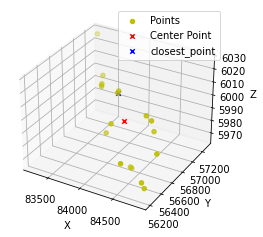

In [146]:

## Testing function with some manually inserted dots
import numpy as np
import matplotlib.pyplot as plt

# Example XYZ coordinates
points = [
    [66659, 85714, 5406],
    [66885, 85749, 5367],
    [67124, 86454, 5390],
    [67664, 86251, 5434],
    [67273, 85576, 5497],
    [66399, 85482, 5428],
    [66803, 85360, 5477],
    [66505, 85552, 5413],
    [66772, 85838, 5450],
    [66496, 85540, 5402],
    [72452, 82402, 5694],
    [75373, 80809, 5808]
]

points = neurons_inputs_LO['post_pt_position'].tolist()

# Convert the points to a NumPy array
points = np.array(points)

# Set the threshold distance to exclude outliers
threshold = 5000

# Find the center point
center_point, closest_point  = find_center_point(points, threshold)

if center_point is not None:
    print("Center Point:", center_point)
else:
    print("No valid points within the threshold.")

# Plotting the points and center point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='y', label='Points')

# Scatter plot for the center point
if center_point is not None:
    ax.scatter(center_point[0], center_point[1], center_point[2], c='r', marker='x', label='Center Point')
    ax.scatter(closest_point [0], closest_point [1], closest_point [2], c='b', marker='x', label='closest_point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

### 4. Saving back to excel file

In [32]:

# Creating string for the date
import datetime
x = datetime.datetime.now()
date_str = x.strftime("%d") + x.strftime("%b") + x.strftime("%Y")

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

df.to_excel(writer, sheet_name='Updated_table_'+date_str) #sorted_df
writer.save()
writer.close()

# C) Updating of list of IDs from a txt file


### 1. Loading the data from a txt file

In [3]:
# Choose path and file
import os

dataPath = r'E:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
fileDate = '20230614'
fileName = f'root_ids_Tm16_side_rigth_exploring.txt'
filePath = os.path.join(dataPath,fileName)
ids_df = pd.read_csv(filePath, sep = ",")
curr_ID_ls = ids_df.columns.tolist()

In [4]:
#Updating the IDs via Fafbseg
updated_ID_df = fafbseg.flywire.update_ids(curr_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/209 [00:00<?, ?it/s]

In [5]:
display(updated_ID_df.head())
print('Update confidences: ')
print(set(updated_ID_df['confidence'].tolist()))

,old_id,new_id,confidence,changed
0,720575940627075224,720575940627075224,1.0,False
1,720575940633124179,720575940633124179,1.0,False
2,720575940635645432,720575940635645432,1.0,False
3,720575940613122218,720575940613122218,1.0,False
4,720575940640263040,720575940640263040,1.0,False


Update confidences: 
{0.98, 1.0, 0.87, 0.96, 0.99, 0.85, 0.97, 0.86, 0.83, 0.55}


In [6]:
updated_ID_df[updated_ID_df['confidence'] < 0.98]

,old_id,new_id,confidence,changed
13,720575940617335001,720575940613334937,0.96,True
25,720575940628379774,720575940618237401,0.87,True
37,720575940659791745,720575940640718243,0.85,True
72,720575940630466860,720575940629384689,0.96,True
107,720575940615506655,720575940620815184,0.96,True
134,720575940629632359,720575940635640986,0.97,True
135,720575940620832532,720575940615388562,0.97,True
152,720575940611260622,720575940614826536,0.86,True
178,720575940625762637,720575940615273639,0.83,True
190,720575940623663640,720575940630663034,0.55,True


In [11]:
updated_ID_df[updated_ID_df['confidence'] < 0.98]['new_id'].tolist()

[720575940613334937,
 720575940618237401,
 720575940640718243,
 720575940629384689,
 720575940620815184,
 720575940635640986,
 720575940615388562,
 720575940614826536,
 720575940615273639,
 720575940630663034,
 720575940630628855]

In [12]:
#Saving the data
updated_fileName = f'Updated_{fileName}'
updated_filePath = os.path.join(dataPath,updated_fileName)

id_list = updated_ID_df['new_id'].tolist()
with open(updated_filePath , "w") as output:
    output.write(str(id_list))


In [13]:
updated_filePath

'E:\\Connectomics-Data\\FlyWire\\Txts\\cell_type_proofread\\Updated_root_ids_Tm16_side_rigth_exploring.txt'